In [19]:
import torch
import numpy as np
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset, random_split
from torch import nn, optim
import matplotlib.pyplot as plt
from pathlib import Path
from typing import List, Tuple, Dict

#### Initial configuration

In [ ]:
filtered_data_dir = Path('data/filtered_images') 
batch_size = 32 
img_size = 224
learning_rate = 0.001
num_epochs = 15 
model_save_path = 'f1_layout_recognizer_v2.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


#### Setup image transformations

In [3]:
data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomRotation(10),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }

#### Custom dataset class with dataloaders and transformations

In [ ]:
class ImageClassificationDataModule:
    """
    Data module for image classification tasks.
    Handles data transforms, train/validation split, and DataLoader creation.
    """
    def __init__(
        self,
        data_dir: str,
        transform: Dict[str, transforms.Compose],
        batch_size: int = 32,
        val_split: float = 0.2,
        image_size: Tuple[int, int] = (224, 224)
    ):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.val_split = val_split
        self.image_size = image_size

        self.train_transforms = transform['train']
        self.val_transforms = transform['val']

        self.train_dataset = None
        self.val_dataset = None

        self.setup()

    def setup(self) -> None:
        full_dataset = datasets.ImageFolder(root=self.data_dir)
        total_samples = len(full_dataset)
        val_size = int(total_samples * self.val_split)
        train_size = total_samples - val_size

        generator = torch.Generator().manual_seed(42)
        train_subset, val_subset = random_split(
            full_dataset, [train_size, val_size], generator=generator
        )

        self.train_dataset = Subset(
            datasets.ImageFolder(root=self.data_dir, transform=self.train_transforms),
            train_subset.indices
        )
        self.val_dataset = Subset(
            datasets.ImageFolder(root=self.data_dir, transform=self.val_transforms),
            val_subset.indices
        )

    def train_dataloader(self) -> DataLoader:
        """Return DataLoader for training set."""
        return DataLoader(
            dataset=self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
        )

    def val_dataloader(self) -> DataLoader:
        """Return DataLoader for validation set."""
        return DataLoader(
            dataset=self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
        )

#### Create dataloaders

In [ ]:
data_module = ImageClassificationDataModule(
        data_dir=filtered_data_dir,
        transform=data_transforms,
        batch_size=batch_size,
        val_split=0.2,
        image_size=(img_size, img_size)
    )
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()

print(f"Train samples: {len(data_module.train_dataset)}")
print(f"Validation samples: {len(data_module.val_dataset)}")

# Iterate through one batch
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}")

Train samples: 879
Validation samples: 219
Batch shape: torch.Size([32, 3, 224, 224])


In [10]:
class_to_idx = data_module.train_dataset.dataset.class_to_idx
print(class_to_idx)
idx_to_class = {v: k for k, v in class_to_idx.items()}
print(idx_to_class)

{'Albert Park Circuit': 0, 'Autódromo Hermanos Rodríguez': 1, 'Bahrain International Circuit': 2, 'Baku City Circuit': 3, 'Circuit Gilles Villeneuve': 4, 'Circuit Zandvoort': 5, 'Circuit de Barcelona-Catalunya': 6, 'Circuit de Monaco': 7, 'Circuit de Spa-Francorchamps': 8, 'Circuit of the Americas': 9, 'Hungaroring': 10, 'Imola (Autodromo Enzo e Dino Ferrari)': 11, 'Interlagos (Autódromo José Carlos Pace)': 12, 'Jeddah Corniche Circuit': 13, 'Las Vegas Street Circuit': 14, 'Lusail International Circuit': 15, 'Marina Bay Street Circuit': 16, 'Miami International Autodrome': 17, 'Monza (Autodromo Nazionale Monza)': 18, 'Red Bull Ring': 19, 'Shanghai International Circuit': 20, 'Silverstone Circuit': 21, 'Suzuka International Racing Course': 22, 'Yas Marina Circuit': 23}
{0: 'Albert Park Circuit', 1: 'Autódromo Hermanos Rodríguez', 2: 'Bahrain International Circuit', 3: 'Baku City Circuit', 4: 'Circuit Gilles Villeneuve', 5: 'Circuit Zandvoort', 6: 'Circuit de Barcelona-Catalunya', 7: 'Ci

#### Setup model class

In [13]:
class EfficientNetModel(nn.Module):
    def __init__(self, num_classes: int):
        super(EfficientNetModel, self).__init__()
        self.model = models.efficientnet_b0(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        for param in self.model.classifier.parameters():
            param.requires_grad = True
        self.model.classifier = nn.Sequential(
            nn.Linear(self.model.classifier[1].in_features, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        return self.model(x)
    def unfreeze(self):
        for param in self.model.parameters():
            param.requires_grad = True
        for param in self.model.classifier.parameters():
            param.requires_grad = True

In [17]:
num_classes = len(class_to_idx)
model = EfficientNetModel(num_classes=num_classes).to(device)

/opt/anaconda3/envs/emotion-env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/emotion-env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
def plot_loss_and_accuracy(
    train_losses: List[float],
    val_losses: List[float],
    train_accs: List[float],
    val_accs: List[float],
    num_epochs: int
) -> None:
    """
    Plot training and validation loss and accuracy.
    """
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(num_epochs), train_losses, label='Training Loss')
    plt.plot(range(num_epochs), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(num_epochs), train_accs, label='Training Accuracy')
    plt.plot(range(num_epochs), val_accs, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

#### Define training function with saving best model state

In [15]:
def train_model(
        model: nn.Module, 
        train_loader: DataLoader, 
        val_loader: DataLoader, 
        num_epochs: int=10, 
        learning_rate: float=0.001, 
        model_save_path: str=model_save_path
        ):
    """
    Train the model using the provided DataLoader.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        if train_accuracy > best_acc:
            best_acc = train_accuracy
            torch.save(model.state_dict(), model_save_path)
            print(f"Model saved with accuracy: {best_acc:.4f}")

        # Validation
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(val_loader)
        val_accuracy = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    plot_loss_and_accuracy(train_losses, val_losses, train_accuracies, val_accuracies, num_epochs)

#### Training model

/opt/anaconda3/envs/emotion-env/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Model saved with accuracy: 0.0865
Epoch [1/15], Train Loss: 3.1112, Train Accuracy: 0.0865, Val Loss: 2.9281, Val Accuracy: 0.1963
Model saved with accuracy: 0.2685
Epoch [2/15], Train Loss: 2.6786, Train Accuracy: 0.2685, Val Loss: 2.5244, Val Accuracy: 0.3425
Model saved with accuracy: 0.4096
Epoch [3/15], Train Loss: 2.2088, Train Accuracy: 0.4096, Val Loss: 2.2946, Val Accuracy: 0.3562
Model saved with accuracy: 0.4949
Epoch [4/15], Train Loss: 1.8699, Train Accuracy: 0.4949, Val Loss: 2.0362, Val Accuracy: 0.4475
Model saved with accuracy: 0.5688
Epoch [5/15], Train Loss: 1.6290, Train Accuracy: 0.5688, Val Loss: 1.9274, Val Accuracy: 0.4475
Model saved with accuracy: 0.5757
Epoch [6/15], Train Loss: 1.4774, Train Accuracy: 0.5757, Val Loss: 1.8992, Val Accuracy: 0.4886
Model saved with accuracy: 0.6041
Epoch [7/15], Train Loss: 1.3941, Train Accuracy: 0.6041, Val Loss: 1.8748, Val Accuracy: 0.4749
Model saved with accuracy: 0.6587
Epoch [8/15], Train Loss: 1.2562, Train Accuracy:

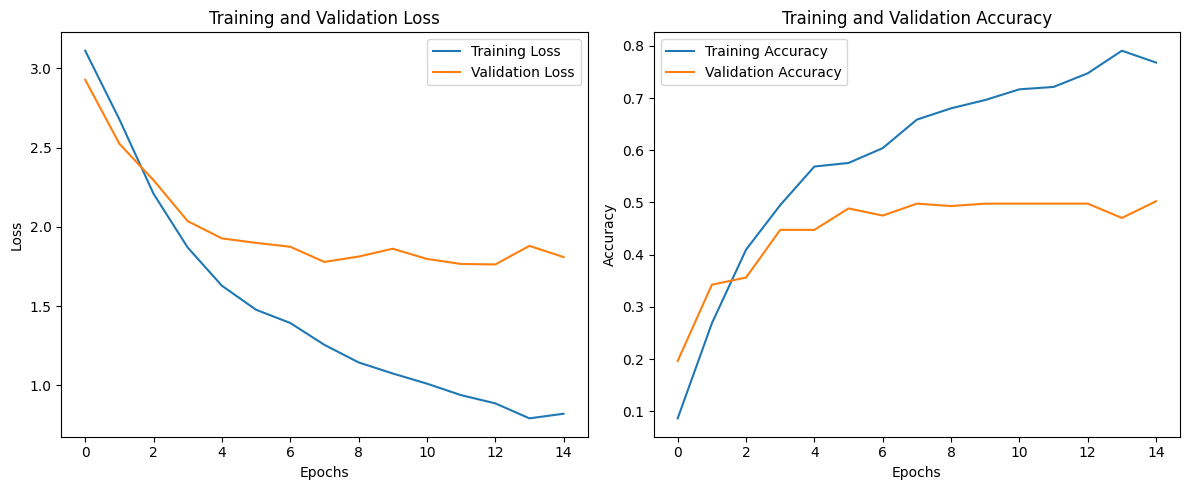

In [16]:
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    model_save_path=model_save_path
)

##### Summary
Validation accuracy is very low but it might be because of messy data and unlucky split between train and val data. This will be further tested.